# Sensitivity analysis of previous work for all experiments and orignal models

## Notebook setup

Allow editing using PyCharm (auto reloading)

In [0]:
%load_ext autoreload
%autoreload 2

Needed for compatibility when using both CoLab and Local Jupyter notebook. It sets the appropriate file path for the data and also installs local packages such as models and data_loading.

In [1]:
import os
import importlib

if os.getcwd() == '/content':
    from google.colab import drive
    drive.mount('/content/gdrive')
    FILE_PATH = '/content/gdrive/My Drive/Level-4-Project/data/'
    !cd gdrive/My\ Drive/Level-4-Project/ && pip install --editable .
    os.chdir('gdrive/My Drive/Level-4-Project/')
    
else:
    FILE_PATH = "C:/Users/macka/Google Drive/Level-4-Project/data/"
    
from src.models.original_models import cifar_initialised, cifar_xdeg, mixed, mixed_angle_A, non_initialised_X, xs
from src.data import load_data

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Obtaining file:///content/gdrive/My%20Drive/Level-4-Project
  Found existing installation: src 0.1.0
    Can't uninstall 'src'. No files were found to uninstall.
  Running setup.py develop for src


Using TensorFlow backend.


Import remaining packages

In [0]:
import numpy as np
import sys
from six.moves import cPickle
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
from keras.utils import np_utils
import sys
from sklearn.metrics import classification_report, confusion_matrix
import csv
from keras.models import load_model
import matplotlib.pyplot as plt

Needed as originally code was for theano backend but now using tensor flow

In [0]:
from keras import backend as K
K.set_image_dim_ordering('th')

## Initialise dictionary that will contain all experiments (models, data folders, etc.)

Setup dictionary that will hold all models and data

In [0]:
default_nb_classes = 7
img_rows, img_cols = 75, 75  # Input image dimensions same for all experiments

In [0]:
experiment_names = [
    "cifar_initialised", "cifar_xdeg", "mixed",
    "mixed_angle_A", "non_initialised_X", "xs"]
experiments = {}
for name in experiment_names:
    experiments[name] = {
        "models": [],
        "data_folders":[],
        "target_names":[
            'ArmFasterTowards', 'ArmSlowerTowards', 'CirclingArm',
            'Clapping', 'PickingUp', 'Sitting', 'Walking'],
        "extra_params":{
            "nb_classes": default_nb_classes,
            "nb_train_samples": None
        }}

## Adding experiments

### cifar_initialised
Training and testing data from all
actions and test subjects, but 0 degrees aspect angle.

In [0]:
for version_number in range(1,5):
    experiments["cifar_initialised"]["models"].append(
        cifar_initialised.make_model(version_number, img_rows, img_cols, default_nb_classes))
experiments["cifar_initialised"]["data_folders"].append("cifar_initialised")
experiments["cifar_initialised"]["extra_params"]["nb_train_samples"] = 35595

### cifar_xdeg
Data with
aspect angles of 30, 45 and 60 degrees respectively, training data from
5 people, testing on person A, no walking test samples.

In [0]:
# 6 classes so have to overwrite default number of classes and target names
nb_classes = 6
experiments["cifar_xdeg"]["models"].append(
    cifar_xdeg.make_model(img_rows, img_cols, nb_classes))
experiments["cifar_xdeg"]["data_folders"] = [
    'cifar_30deg', 'cifar_45deg', 'cifar_60deg']
experiments["cifar_xdeg"]["extra_params"]["nb_classes"] = nb_classes
experiments["cifar_xdeg"]["extra_params"]["nb_train_samples"] = 34260
experiments["cifar_xdeg"]["target_names"] = [
    'ArmFasterTowards', 'ArmSlowerTowards', 'CirclingArm',
    'Clapping', 'PickingUp', 'Sitting']

### mixed
Training and testing data from all test subjects
and aspect angles, excluding the walking samples.

In [0]:
# ADD EARLY STOPPING TO MIXED? (Takes the longest by a significant amount)
for version_number in range(1,3):
    experiments["mixed"]["models"].append(
        mixed.make_model(version_number, img_rows, img_cols, default_nb_classes))
experiments["mixed"]["data_folders"].append("mixed")
experiments["mixed"]["extra_params"]["nb_train_samples"] = 52695

### mixed_angle_A
Training data from all actions, test subjects and aspect angles, excluding the data from person A, which
is used for testing, and excluding the walking samples.

In [0]:
experiments["mixed_angle_A"]["models"].append(
    mixed_angle_A.make_model(img_rows, img_cols, default_nb_classes))
experiments["mixed_angle_A"]["data_folders"].append("mixed_angle_A")
experiments["mixed_angle_A"]["extra_params"]["nb_train_samples"] = 43450

### non_initialised_X
Training data from 5 people and testing data
from 1 person, with 0 degree aspect angle, all actions.  The letter (A, B, C or D)
signifies the person whose data is used for the test samples.

In [0]:
experiments["non_initialised_X"]["models"].append(
    non_initialised_X.make_model(img_rows, img_cols, default_nb_classes))
experiments["non_initialised_X"]["data_folders"] = [
    'noninitialised_A',
    'noninitialised_B',
    'noninitialised_C',
    'noninitialised_D']
experiments["non_initialised_X"]["extra_params"]["nb_train_samples"] = 34720

### xs
Training data from 5 people, testing
from person A, with spectrogram ”window”, or duration of 1.5, 1 and
2 seconds respectively and 0.1 second ”shift"

In [0]:
experiments["xs"]["models"].append(xs.make_model(img_rows, img_cols, default_nb_classes))
experiments["xs"]["data_folders"] = ['1s', '1_5s', '2s']
experiments["xs"]["extra_params"]["nb_train_samples"] = 34720

## Learning parameters

In [0]:
batch_size = 100
nb_epoch = 50
data_augmentation = False

## Training and Results

In [0]:
def plot_loss(history):
    # Get training and test loss histories
    training_loss = history.history['loss']
    test_loss = history.history['val_loss']

    # Create count of the number of epochs
    epoch_count = range(1, len(training_loss) + 1)

    # Visualize loss history
    plt.plot(epoch_count, training_loss, 'r--')
    plt.plot(epoch_count, test_loss, 'b-')
    plt.legend(['Training Loss', 'Test Loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show();

<keras.models.Sequential object at 0x7f5a1adeae48> cifar_initialised
X_train shape: (35595, 1, 75, 75)
35595 train samples
7119 test samples
Not using data augmentation.
Train on 35595 samples, validate on 7119 samples
Epoch 1/50
35595/35595 [==============================] - 19s 548us/step - loss: 0.0086 - acc: 0.9974 - val_loss: 0.0383 - val_acc: 0.9931
Epoch 2/50
35595/35595 [==============================] - 19s 535us/step - loss: 0.0089 - acc: 0.9972 - val_loss: 0.0321 - val_acc: 0.9935
Epoch 3/50
35595/35595 [==============================] - 19s 541us/step - loss: 0.0072 - acc: 0.9976 - val_loss: 0.0282 - val_acc: 0.9938
Epoch 4/50
35595/35595 [==============================] - 19s 536us/step - loss: 0.0080 - acc: 0.9973 - val_loss: 0.0458 - val_acc: 0.9928
Epoch 5/50
35595/35595 [==============================] - 19s 535us/step - loss: 0.0056 - acc: 0.9980 - val_loss: 0.0286 - val_acc: 0.9940
Epoch 6/50
35595/35595 [==============================] - 19s 537us/step - loss: 0.007

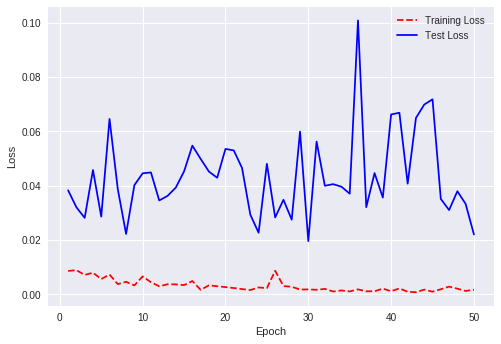

<keras.models.Sequential object at 0x7f5a15514eb8> cifar_initialised
X_train shape: (35595, 1, 75, 75)
35595 train samples
7119 test samples
Not using data augmentation.
Train on 35595 samples, validate on 7119 samples
Epoch 1/50
35595/35595 [==============================] - 32s 907us/step - loss: 0.5156 - acc: 0.8066 - val_loss: 0.0980 - val_acc: 0.9612
Epoch 2/50
35595/35595 [==============================] - 30s 855us/step - loss: 0.0826 - acc: 0.9716 - val_loss: 0.0516 - val_acc: 0.9802
Epoch 3/50
35595/35595 [==============================] - 31s 858us/step - loss: 0.0443 - acc: 0.9846 - val_loss: 0.0685 - val_acc: 0.9772
Epoch 4/50
35595/35595 [==============================] - 31s 859us/step - loss: 0.0279 - acc: 0.9901 - val_loss: 0.0639 - val_acc: 0.9799
Epoch 5/50
35595/35595 [==============================] - 31s 857us/step - loss: 0.0171 - acc: 0.9943 - val_loss: 0.0524 - val_acc: 0.9844
Epoch 6/50
35595/35595 [==============================] - 31s 857us/step - loss: 0.014

In [0]:
%%time
for name, experiment in experiments.items():
    for model in experiment["models"]:
        for data_folder in experiment["data_folders"]:
            print(model, data_folder)
            # the data, shuffled and split between train and test sets
            path = FILE_PATH + data_folder
            nb_train_samples = experiment["extra_params"]["nb_train_samples"]
            nb_classes = experiment["extra_params"]["nb_classes"]
            (X_train, y_train), (X_test, y_test) = load_data.load_data(path, nb_train_samples)
            print('X_train shape:', X_train.shape)
            print(X_train.shape[0], 'train samples')
            print(X_test.shape[0], 'test samples')

            # convert class vectors to binary class matrices
            Y_train = np_utils.to_categorical(y_train, nb_classes)
            Y_test = np_utils.to_categorical(y_test, nb_classes)
            
            # let's train the model using SGD + momentum (how original).
            sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
            model.compile(loss='categorical_crossentropy',
                          optimizer=sgd,
                          metrics=['accuracy'])

            X_train = X_train.astype('float32')
            X_test = X_test.astype('float32')
            X_train /= 255
            X_test /= 255 
            if not data_augmentation:
                print('Not using data augmentation.')
                hist = model.fit(X_train, Y_train,
                          batch_size=batch_size,
                          epochs=nb_epoch,
                          validation_data=(X_test, Y_test),
                          shuffle=True)
                plot_loss(hist)

#                 y_pred = model.predict_classes(X_test)
#                 print(y_pred)
#                 target_names = ['ArmFasterTowards', 'ArmSlowerTowards', 'CirclingArm', 'Clapping', 'PickingUp', 'Sitting', 'Walking']
#         #         sys.stdout = open('/home/aleksandar/sets/cifar_initialised/results/report_initialised.txt', "w")
#                 print("CLASSIFICATION REPORT:")
#                 print(classification_report(np.argmax(Y_test,axis=1), y_pred,target_names=target_names))
#                 print ("\n")
#                 print("CONFUSION MATRIX:")
#                 print(confusion_matrix(np.argmax(Y_test,axis=1), y_pred))